In [423]:
import numpy as np
import sys
sys.path.insert(0, '/Library/Application Support/MWorks/Scripting/Python')
from mworks.data import MWKFile
import matplotlib.pyplot as plt
import matplotlib.style as style 
import pandas as pd
from scipy.stats import linregress

style.use('seaborn-poster') 
style.use('seaborn-white')

In [230]:
username = 'aidapiccato'
dir_path = '/Users/%s/PyCharmProjects/concentration/concentration-game-mworks' % username
subject_id = 0

In [231]:
## sync times 
ITI = 1
TRIAL_INIT = 2
FLIP_CARD_A = 3
FLIP_CARD_B = 4
FEEDBACK = 5
TRIAL_END = 6

In [232]:
class Unpack():    
    def __init__(self, fn):
        fpath = '/Users/%s/Documents/MWorks/Data' % username
        self.fn = fn        
        self.f =  MWKFile('%s/%s' % (fpath, fn))
        self.f.open()
        self.codec = self.f.codec
        self.codenames = ['card_b', 'card_a',  'grid', 'grid_dims', 'inv_grid', 'n_pairs', 'block_index', 'success', 'ignore', 'failure', 'trial_index'] 
        self.start_sync_t, self.end_sync_t = self.get_sync_times()
        self.n_trials = len(self.start_sync_t)
        print('Collecting %d trials of data' % self.n_trials)
        self.avg_trial_dur = (self.end_sync_t - self.start_sync_t) / 10**6
        print('Average trial duration: %f seconds' % np.mean(self.avg_trial_dur))        
        self.scalar = self.get_scalar_data()        

                
    def get_scalar_data(self):
        data_scalar = {'dur': [], 'card_a_img': [], 'card_b_img': [], 'card_c': [], 'dist_a_b': [], 'dist_b_c': [], 
                       'success': [], 'failure': [], 'card_a_t': [], 'trial_index': []}
        
        for c in self.codenames:
            data_scalar[c] = []

        for trial in range(self.n_trials):            
            start_t, end_t = np.long(self.start_sync_t[trial]), np.long(self.end_sync_t[trial])
            trial_events = self.f.get_events(codes = self.codenames, time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])         
            # trial duration        
            data_scalar['dur'].append((end_t - start_t)/10**6)        
            for ci, c in enumerate(self.codenames): # currently this is only selecting card_b                
                code = self.f.reverse_codec[c]
                code_events = trial_events[np.where(trial_events[:, 0] == code)[0], 2]
                data_scalar[c].append(code_events[0])                    
            
            card_a = data_scalar['card_a'][trial]
            card_b = data_scalar['card_b'][trial]
            grid = np.asarray(data_scalar['grid'][trial])
            match = np.where(grid == grid[card_a])[0]            
            card_c = match[match != card_a]                
            
            data_scalar['card_c'].append(card_c[0])
            
            data_scalar['card_a_img'].append(data_scalar['grid'][trial][card_a])
            data_scalar['card_b_img'].append(data_scalar['grid'][trial][card_b])
            
            # distance between locations of card a and b
            data_scalar['dist_a_b'].append(self.get_dist(card_a, card_b, data_scalar['grid_dims'][trial]))
            
            # distance between locations of card b and correct card
            data_scalar['dist_b_c'].append(self.get_dist(card_b, card_c, data_scalar['grid_dims'][trial]))

        data_scalar['rt'] = self.get_reaction_times() 
        data_scalar['card_a_t'] = self.get_t(FLIP_CARD_A)

        data_scalar = pd.DataFrame(data_scalar)
        
        return data_scalar
    
    def get_t(self, sync):

        sync_events = self.f.get_events(codes = ['sync'])
        sync_events = np.asarray([[e.code, e.time, e.data] for e in sync_events])
        sync_events = sync_events[np.where(sync_events[:, 2] == sync)[0], 1]
        return sync_events

    
    def get_analog_data(self):
        data_analog = {'card': [], 'trial_index': [], 'time': [], 'block_index': [], 'flipped': []} 
        
        for t in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[t]), np.long(self.end_sync_t[t])
            trial_events = self.f.get_events(codes=['sync'], time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])
            card_a_t = trial_events[np.where(trial_events[:, 2] == FLIP_CARD_A)[0], 1]
            card_b_t = trial_events[np.where(trial_events[:, 2] == FLIP_CARD_B)[0], 1]
            
            data_analog['card'].append(self.scalar['card_a'][t])
            data_analog['trial_index'].append(t)
            data_analog['time'].append(card_a_t[0])
            data_analog['block_index'].append(self.scalar['block_index'][t])
            data_analog['flipped'].append(False)
            
            
            if len(card_b_t) > 0:
                data_analog['card'].append(self.scalar['card_b'][t])
                data_analog['trial_index'].append(t)
                data_analog['time'].append(card_b_t[0])         
                data_analog['block_index'].append(self.scalar['block_index'][t])
                data_analog['flipped'].append(True)
                        
        data_analog = pd.DataFrame(data_analog)    
        data_analog.reset_index(inplace=True)
                                               
        return data_analog
    
    def get_sync_times(self): 
        sync_events = self.f.get_events(codes=['sync'])
        sync_events = np.asarray([[e.data, e.time] for e in sync_events])        
        end_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_END)[0], 1]
        start_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_INIT)[0], 1]
        start_sync_t = start_sync_t[:len(end_sync_t)]
        return start_sync_t, end_sync_t
    
    def get_dist(self, card_a, card_b, grid_dims): 
        card_a_loc = np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]])
        card_b_loc = np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]])
        return np.linalg.norm(card_a_loc - card_b_loc)
    
    def get_reaction_times(self):
        rts = []
        for trial in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[trial]), np.long(self.end_sync_t[trial])
            sync = self.f.get_events(codes = ['sync'], time_range=[start_t, end_t])
            sync = np.asarray([[e.data, e.time] for e in sync])                
            flip_card_a = sync[np.where(sync[:, 0] == FLIP_CARD_A)[0], 1]
            flip_card_b = sync[np.where(sync[:, 0] == FLIP_CARD_B)[0], 1]                    
            if len(flip_card_b) == 0:
                flip_card_b = [flip_card_a]
            rt = np.long(flip_card_b[0]) - np.long(flip_card_a[0])
            rts.append(rt/10**6)
        return rts

In [233]:
fn = "aidapiccato-concentration-ios-20200124-150507.mwk2"
unpack = Unpack(fn)

Average trial duration: 1.780989 seconds


In [234]:
class Analysis:
    def __init__(self, unpack):
        self.scalar = unpack.scalar
        self.card_views = unpack.get_analog_data()
        self.spatial_dist = self.get_spatial_dist()
        self.temporal_dist = self.get_temporal_dist()
        self.n_trials = len(self.scalar)        
        
    def get_spatial_dist(self):
        spatial_dist = pd.DataFrame()
        spatial_dist['dist_a_b'] = self.scalar.apply(lambda t: self.get_dist_norm(t.card_a, t.card_b, t.grid_dims), 
                                                     axis=1)
        spatial_dist['dist_a_c'] = self.scalar.apply(lambda t: self.get_dist_norm(t.card_a, t.card_c, t.grid_dims), 
                                                     axis=1)
        spatial_dist['dist_b_c'] = self.scalar.apply(lambda t: self.get_dist_norm(t.card_b, t.card_c, t.grid_dims), 
                                                     axis=1)
        return spatial_dist
    
    def get_temporal_dist(self):
        temporal_dist = pd.DataFrame()
        # time since card_c was last seen
        temporal_dist['t_c'] = self.scalar.apply(lambda t: self.get_t_dist_cont(t.card_c, t.trial_index, \
                                                                                t.block_index), axis=1)
        # time since card_b was last seen
        temporal_dist['t_b'] = self.scalar.apply(lambda t: self.get_t_dist_cont(t.card_b, t.trial_index, \
                                                                                t.block_index), axis=1)
        # number of cards since card_c was last seen
        temporal_dist['n_imgs_c'] = self.scalar.apply(lambda t: self.get_t_dist_disc(t.card_c, t.trial_index,
                                                                                    t.block_index), axis=1)            
        # number of cards since card_b was last seen
#         temporal_dist['n_imgs_b'] = self.scalar.apply(lambda t: self.get_t_dist_disc(t.card_b, t.trial_index, 
#                                                                                     t.block_index), axis=1)                 
        return temporal_dist
        
    def get_t_dist_cont(self, card, trial_index, block_index):     
        last_t = self.card_views[self.card_views.card.eq(card) & self.card_views.block_index.eq(block_index) & 
                                 self.card_views.trial_index.lt(trial_index)]
        
        if len(last_t) > 0:
            return last_t.iloc[-1].time
        return -1    
    
    def get_t_dist_disc(self, card, trial_index, block_index):
        last_t = self.card_views[self.card_views.card.eq(card) & self.card_views.block_index.eq(block_index) & 
                                 self.card_views.trial_index.lt(trial_index)]
        curr_t = self.card_views[self.card_views.block_index.eq(block_index) & 
                                 self.card_views.trial_index.eq(trial_index)].iloc[0]

        if len(last_t) > 0:
            return curr_t['index'] - last_t.iloc[-1]['index']
        
        return -1
        
    def get_dist_norm(self, card_a, card_b, grid_dims): 
        card_a_loc = np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]])
        card_b_loc = np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]])
        max_dist = np.linalg.norm(np.asarray([0, 0]) - np.asarray([grid_dims[0]-1, grid_dims[1]-1]))
        return np.linalg.norm(card_a_loc - card_b_loc)/max_dist
    
    def spatial_performance():
        df = pd.concat([self.spatial_dist, self.scalar.success])
        

In [235]:
card = 6
trial_index = 0
block_index = 0
# Int64Index([], dtype='int64') 6 13 0

In [236]:
card_views = unpack.get_analog_data()

In [264]:
a = Analysis(unpack)

<ErrorbarContainer object of 3 artists>

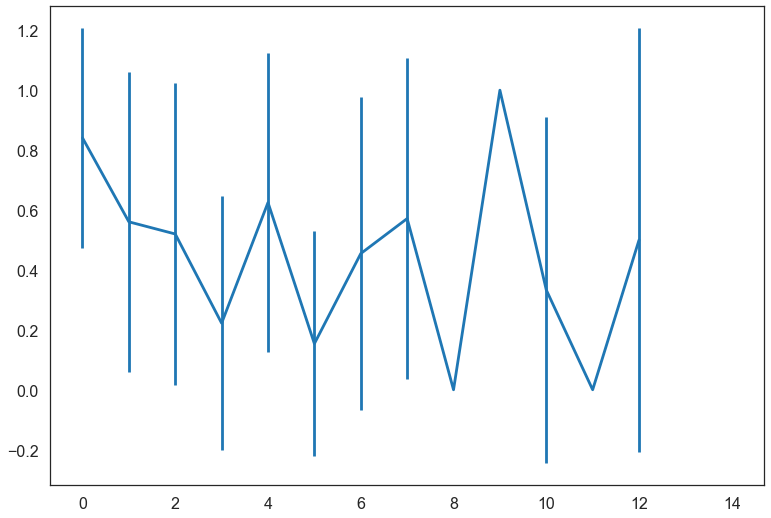

In [241]:
df = pd.concat([a.temporal_dist, a.scalar.success, a.scalar.card_a_t], axis=1)
# time since card c last seen
df = df[df.t_c != -1]
n_bins = 15
df['dist_c'] = df.card_a_t - df.t_c
df['dist_c_bin'] = pd.cut(df.dist_c, n_bins)
plt.errorbar(np.arange(n_bins), df.groupby('dist_c_bin')['success'].mean(), yerr=df.groupby('dist_c_bin')['success'].std())

<ErrorbarContainer object of 3 artists>

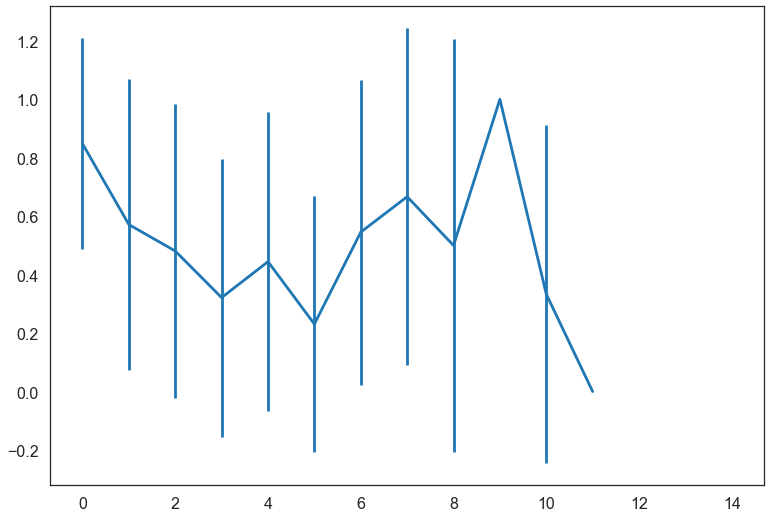

In [242]:
df = pd.concat([a.temporal_dist, a.scalar.success, a.scalar.card_a_t], axis=1)
# time since card c last seen 
df = df[df.n_imgs_c != -1]
df['n_imgs_c_bin'] = pd.cut(df.n_imgs_c, 15)
plt.errorbar(np.arange(15), df.groupby('n_imgs_c_bin')['success'].mean(), df.groupby('n_imgs_c_bin')['success'].std())

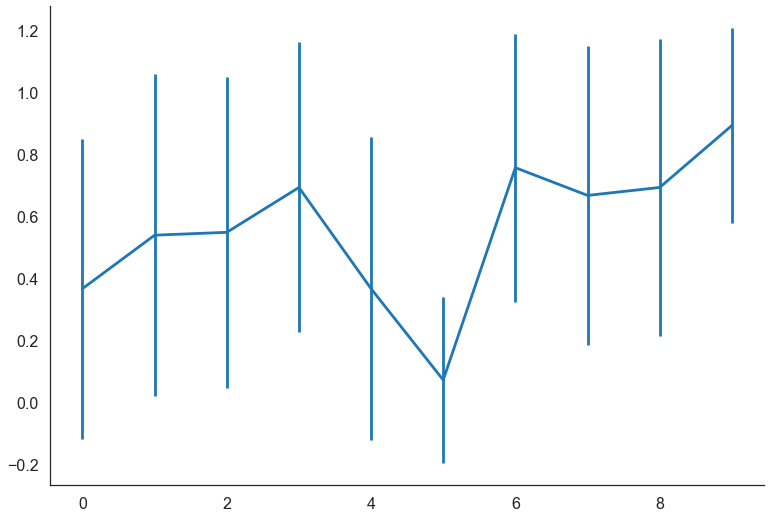

In [243]:
df = pd.concat([a.spatial_dist, a.scalar.success], axis=1)
df['dist_a_b_bin'] = pd.cut(df.dist_a_b, 10)
plt.errorbar(np.arange(10), df.groupby('dist_a_b_bin')['success'].mean(), df.groupby('dist_a_b_bin')['success'].std())
prettify(plt.gca())

# Performance measures
- Average percentage successful trials for each block size 

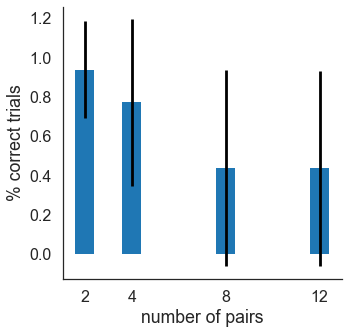

In [286]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(np.sort(a.scalar['n_pairs'].unique()), a.scalar.groupby('n_pairs')['success'].mean(), yerr=a.scalar.groupby('n_pairs')['success'].std())
ax.set_xticks(np.sort(a.scalar['n_pairs'].unique()))
ax.set_xlabel('number of pairs')
ax.set_ylabel('% correct trials')
prettify(ax)
plt.show()

- $Pr (selecting correct card)$ over time, averaged across blocks of the same size (learning trajectory)
- Distance of selected card from correct, averaged across blocks of the same size 

In [ ]:
df1, df2 = [x for _, x in df.groupby(df['Sales'] < 30)]

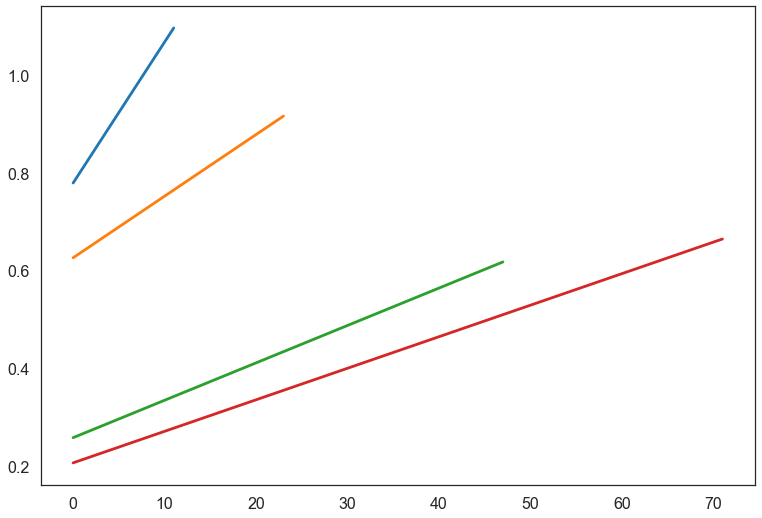

In [433]:
a.scalar['n_success'] = a.scalar.groupby('block_index')['success'].cumsum()
df = pd.concat([a.scalar.success, a.scalar.n_pairs, a.scalar.block_index], axis=1)
grouped = df.groupby('n_pairs')
f, ax = plt.subplots(1, 1)
max_n_trials = 12 * 2 * 3
for i, (k, group) in enumerate(grouped):
    group = pd.DataFrame(group)
    n_trials = k * 2 * 3
    n_total_trials = len(group.index)
    group.loc[:, 'trial_in_block'] = np.arange(n_total_trials) % n_trials
    group.set_index('trial_in_block')
#     ax[int(i/2), int(i%2)].scatter(np.linspace(0, max_n_trials, n_trials), group.groupby('trial_in_block')['success'].mean(), label=k)
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(n_trials), group.groupby('trial_in_block')['success'].mean())
    abline_values = [slope * i + intercept for i in np.arange(n_trials)]
    ax.plot(abline_values, label=k)

In [426]:
np.linspace(0, 10, 3)

array([], dtype=int64)

In [42]:
def prettify(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.title.set_style('italic')
    ax.title.set_size(15)